In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

print("Carregando dados limpos...")
df = pd.read_csv('data/dados_limpos.csv')


# O alvo é a coluna 'Obesidade'
X = df.drop(['Obesidade'], axis=1)
y = df['Obesidade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dados prontos! Treinando com {len(X_train)} pacientes e testando com {len(X_test)}...")


# Random Forest é excelente para esse tipo de dado tabular
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)


predicoes = modelo.predict(X_test)
acuracia = accuracy_score(y_test, predicoes)

print(f" ACURÁCIA DO MODELO: {acuracia:.2%}") 


joblib.dump(modelo, 'modelo.pkl')

print("'modelo.pkl' salvo com sucesso!")
print("Agora você tem tudo para o Streamlit: modelo.pkl, scaler.pkl e target_map.pkl")

Carregando dados limpos...
Dados prontos! Treinando com 1688 pacientes e testando com 423...
--------------------------------------------------
🎯 ACURÁCIA DO MODELO: 99.53%
--------------------------------------------------
✅ 'modelo.pkl' salvo com sucesso!
Agora você tem tudo para o Streamlit: modelo.pkl, scaler.pkl e target_map.pkl


Média da Validação Cruzada: 97.63% (+/- 6.72%)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.97      1.00      0.98        62
           2       1.00      0.98      0.99        56
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        78
           5       1.00      1.00      1.00        58
           6       1.00      1.00      1.00        63

    accuracy                           1.00       423
   macro avg       1.00      0.99      1.00       423
weighted avg       1.00      1.00      1.00       423



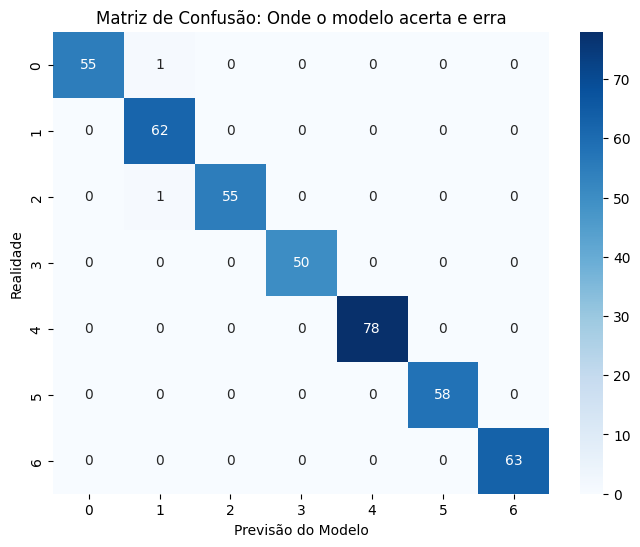

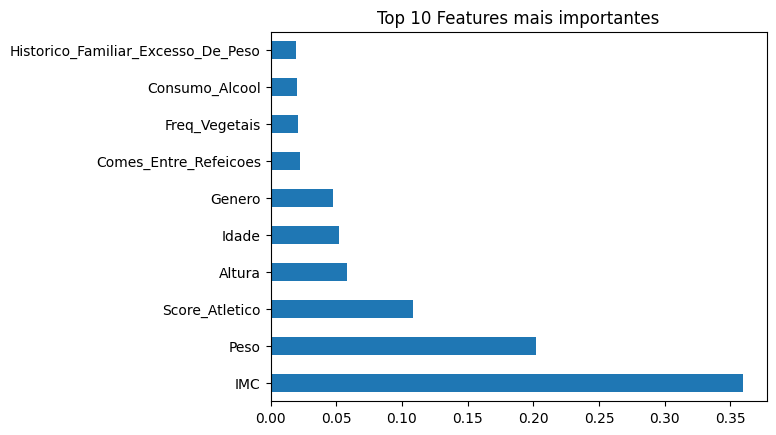

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


#  Validação Cruzada 
scores = cross_val_score(modelo, X, y, cv=5)
print(f"Média da Validação Cruzada: {scores.mean():.2%} (+/- {scores.std()*2:.2%})")

# Relatório Detalhado por Classe
y_pred = modelo.predict(X_test)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#  Gráfico da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão: Onde o modelo acerta e erra')
plt.xlabel('Previsão do Modelo')
plt.ylabel('Realidade')
plt.show()

# O que o modelo mais valoriza?
importances = pd.Series(modelo.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features mais importantes')
plt.show()

Esse (+/- 6.72%) é o desvio padrão. Ele indica que, dependendo de como os dados são divididos, a acurácia do modelo varia bastante (pode cair para ~91% ou subir para 100%).

Então, o objetivo agora não é apenas aumentar a acurácia (que já é alta), mas aumentar a ESTABILIDADE (reduzir esse +/- 6.72%), para garantir que o modelo não "decore" os dados (overfitting).


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir a "grade" de parâmetros que queremos testar
# Vamos testar limitar a profundidade (max_depth) para evitar decorar os dados
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árvores
    'max_depth': [None, 10, 20],          # Profundidade máxima da árvore
    'min_samples_split': [2, 5],          # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2],           # Mínimo de amostras em uma folha
    'bootstrap': [True, False]            # Método de amostragem
}

# Configurar a busca (GridSearchCV)
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1)

print("Iniciando a busca pelos melhores parâmetros (isso pode demorar um pouco)...")
grid_search.fit(X_train, y_train)

# Mostrar o melhor resultado
print(f"\nMelhores Parâmetros encontrados: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Testar o novo modelo otimizado
nova_acuracia = best_model.score(X_test, y_test)
print(f"Acurácia do Modelo Otimizado: {nova_acuracia:.2%}")

Iniciando a busca pelos melhores parâmetros (isso pode demorar um pouco)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Melhores Parâmetros encontrados: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Acurácia do Modelo Otimizado: 99.29%


In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Criar e treinar
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Avaliar
acc_xgb = xgb.score(X_test, y_test_encoded)
print(f"Acurácia XGBoost: {acc_xgb:.2%}")

Acurácia XGBoost: 98.58%


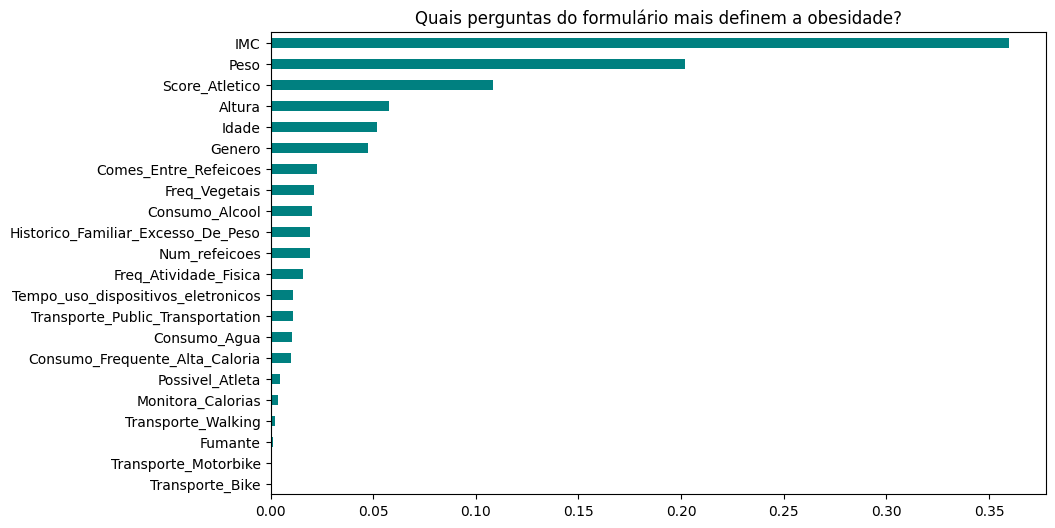

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Pegando as importâncias do seu modelo atual
importances = pd.Series(modelo.feature_importances_, index=X.columns)

# Plot
plt.figure(figsize=(10,6))
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Quais perguntas do formulário mais definem a obesidade?')
plt.show()

In [14]:
import joblib

joblib.dump(best_model, 'modelo.pkl')

print("Modelo salvo!")

✅ Modelo salvo! Faça o download do arquivo 'modelo.pkl' agora.


In [15]:
# Validação Cruzada 
scores = cross_val_score(best_model, X, y, cv=5)
print(f"Média da Validação Cruzada: {scores.mean():.2%} (+/- {scores.std()*2:.2%})")

Média da Validação Cruzada: 98.01% (+/- 4.86%)
